In [66]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn import linear_model
import mlflow
import pickle

In [67]:
df = pd.read_csv("AmesHousing.csv")

In [68]:
df.head()

,Order,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
0,1,526301100,20,RL,141.0,31770,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,NaN,0,5,2010,WD,Normal,215000
1,2,526350040,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,...,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal,105000
2,3,526351010,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal,172000
3,4,526353030,20,RL,93.0,11160,Pave,NaN,Reg,Lvl,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,244000
4,5,527105010,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,...,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal,189900


In [69]:
#selected features: Lot area, Gr Liv Area, Garage Area, Blg type, Saleprice
#Blg type is a categorical value so need to convert it to numerical value using One hot encoding.
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder(sparse_output=False)
encoded_array = encoder.fit_transform(df[['Bldg Type']])
encoded_df = pd.DataFrame(
    encoded_array, 
    columns=encoder.get_feature_names_out(['Bldg Type'])
)
data = pd.concat([df, encoded_df], axis=1)
data

,Order,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice,Bldg Type_1Fam,Bldg Type_2fmCon,Bldg Type_Duplex,Bldg Type_Twnhs,Bldg Type_TwnhsE
0,1,526301100,20,RL,141.0,31770,Pave,NaN,IR1,Lvl,...,5,2010,WD,Normal,215000,1.0,0.0,0.0,0.0,0.0
1,2,526350040,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,...,6,2010,WD,Normal,105000,1.0,0.0,0.0,0.0,0.0
2,3,526351010,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,...,6,2010,WD,Normal,172000,1.0,0.0,0.0,0.0,0.0
3,4,526353030,20,RL,93.0,11160,Pave,NaN,Reg,Lvl,...,4,2010,WD,Normal,244000,1.0,0.0,0.0,0.0,0.0
4,5,527105010,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,...,3,2010,WD,Normal,189900,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2925,2926,923275080,80,RL,37.0,7937,Pave,NaN,IR1,Lvl,...,3,2006,WD,Normal,142500,1.0,0.0,0.0,0.0,0.0
2926,2927,923276100,20,RL,NaN,8885,Pave,NaN,IR1,Low,...,6,2006,WD,Normal,131000,1.0,0.0,0.0,0.0,0.0
2927,2928,923400125,85,RL,62.0,10441,Pave,NaN,Reg,Lvl,...,7,2006,WD,Normal,132000,1.0,0.0,0.0,0.0,0.0
2928,2929,924100070,20,RL,77.0,10010,Pave,NaN,Reg,Lvl,...,4,2006,WD,Normal,170000,1.0,0.0,0.0,0.0,0.0


In [ ]:
mlflow.set_tracking_uri("http://localhost:5000")
mlflow.set_experiment("Model exercise:")

<Experiment: artifact_location='file:///Users/riddhishah/Documents/GitHub/House_rate_prediction_using_mlflow/mlruns/294163132937596845', creation_time=1737318492463, experiment_id='294163132937596845', last_update_time=1737318492463, lifecycle_stage='active', name='Dropping columns:', tags={}>

In [71]:
#load dataset 
data = pd.read_csv("AmesHousing.csv")
feature_columns = ['Lot Area','Gr Liv Area', 'Garage Area', 'Bldg Type']
selected_feature = data.loc[:, feature_columns + ['SalePrice']]

In [72]:
categorical_feature = ['Bldg Type']

In [73]:
def prepare_data(data):
    df = data
    for col in list(data.columns):
        if col in categorical_feature:
            dummies = pd.get_dummies(df[col])
            df = pd.concat([df.drop([col], axis=1), dummies], axis=1)
    df = df.fillna(0)
    return df

In [74]:
def train_and_evaluate(data):
    features = data.drop(['SalePrice'], axis=1).to_numpy()
    target = data.loc[:, 'SalePrice'].to_numpy()
    X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)
    
    #plot 
    plot = data.plot.scatter(x=0, y="SalePrice")
    fig = plot.get_figure()
    fig.savefig("tmp/plot.png")

    #save the data  
    data.to_csv("tmp/dataset.csv", index=False)

    #train the model
    model = linear_model.LinearRegression()
    model.fit(X_train, y_train)

    #save the model 
    serialized_model = pickle.dumps(model)
    with open("tmp/model.pkl", "wb") as f:
        f.write(serialized_model)

    #tsaved single artifact file but cannot visualize its contents in UI as its a binary file
    mlflow.log_artifact("tmp/model.pkl", artifact_path="models")

    #evaluate the model
    y_pred = model.predict(X_test)
    err = mean_squared_error(y_test, y_pred)
    mlflow.log_metric("MSE:", err)


🏃 View run melodic-dove-513 at: http://localhost:5000/#/experiments/294163132937596845/runs/c649cea8803c4f7386b7f604dc27ba1c
🧪 View experiment at: http://localhost:5000/#/experiments/294163132937596845


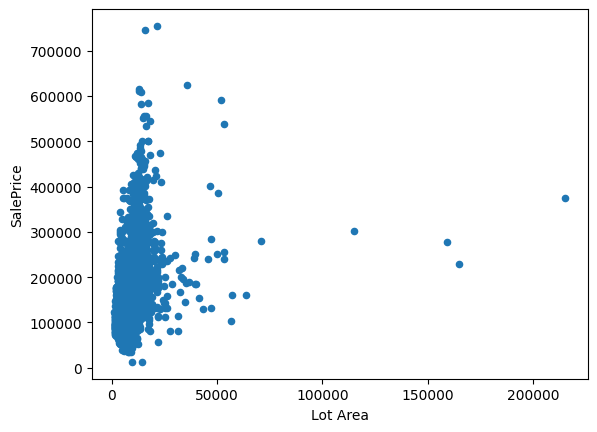

In [76]:
with mlflow.start_run():
    prepared = prepare_data(selected_feature)
    train_and_evaluate(prepared)
